# A Case Study in Bayesian Survival Analysis with **Turing.jl**

<a target="_blank" href="https://colab.research.google.com/github/TuringLang/Turing-Workshop/blob/sunxd/KI_method_week/2025-Karolinska-Institutet/code.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [46]:
using Pkg

Pkg.activate(;temp=true)

dependencies = [
    "RDatasets",
    "DataFrames",

    "Turing",
    "DynamicPPL",
    "MCMCChains",

    "Plots",
    "StatsPlots",
    
    "ArviZ",
    "ArviZPythonPlots",
    "DimensionalData",

    "ReverseDiff",
    "Mooncake",
]

for dep in dependencies
    Pkg.add(dep)
end

  Activating new project at `/var/folders/mw/vylkscl95f1_5ph5t7ntrfh40000gn/T/jl_6NMsKR`
   Resolving package versions...
    Updating `/private/var/folders/mw/vylkscl95f1_5ph5t7ntrfh40000gn/T/jl_6NMsKR/Project.toml`
  [ce6b1742] + RDatasets v0.7.7
    Updating `/private/var/folders/mw/vylkscl95f1_5ph5t7ntrfh40000gn/T/jl_6NMsKR/Manifest.toml`
  [336ed68f] + CSV v0.10.15
  [324d7699] + CategoricalArrays v0.10.8
  [944b1d66] + CodecZlib v0.7.8
  [34da2185] + Compat v4.16.0
  [a8cc5b0e] + Crayons v4.1.1
  [9a962f9c] + DataAPI v1.16.0
  [a93c6f00] + DataFrames v1.7.0
  [864edb3b] + DataStructures v0.18.22
  [e2d170a0] + DataValueInterfaces v1.0.0
  [e2ba6199] + ExprTools v0.1.10
  [5789e2e9] + FileIO v1.17.0
  [48062228] + FilePathsBase v0.9.24
  [842dd82b] + InlineStrings v1.4.3
  [41ab1584] + InvertedIndices v1.3.1
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [b964fa9f] + LaTeXStrings v1.4.0
  [e1d29d7a] + Missings v1.2.0
  [78c3b35d] + Mocking v0.8.1
  [bac558e1] + OrderedCollect

_The following cell contains some utility functions._

In [47]:
using DynamicPPL
using MCMCChains
using Plots
using StatsPlots
using Survival

function plot_prior_pred_check(
    model::DynamicPPL.Model, 
    prior_samples::MCMCChains.Chains, 
    y,
    event
)    
    returned_values = returned(model, prior_samples)
    p_prior = plot(
        title = "Prior Predictive Check",
        xlabel = "Time (days)",
        ylabel = "Survival Probability",
        legend = :topright,
        size = (800, 600),
        left_margin = 10mm,
        right_margin = 10mm,
        top_margin = 10mm,
        bottom_margin = 10mm,
        ylims = (0, 1.05)
    )

    km_obs = fit(KaplanMeier, y, event)
    plot!(p_prior, 
        km_obs.events.time, 
        km_obs.survival,
        seriestype = :steppost,
        label = "Observed Data",
        color = :black,
        linewidth = 2
    )

    for returned_value in returned_values
        y_sim = returned_value.y
        km_sim = fit(KaplanMeier, y_sim, event)
        plot!(p_prior, 
            km_sim.events.time, 
            km_sim.survival,
            seriestype = :steppost,
            label = "",
            color = :lightblue,
            xlims = (0, maximum(y) * 1.1),
            alpha = 0.3
        )
    end
    display(p_prior)
end

function plot_posterior_pred_check(
    model::DynamicPPL.Model,
    posterior_samples::MCMCChains.Chains, 
    y, 
    event,
)
    p_post = plot(
        title = "Posterior Predictive Check",
        xlabel = "Time (days)",
        ylabel = "Survival Probability",
        legend = :topright,
        size = (800, 600),
        left_margin = 10mm,
        right_margin = 10mm,
        top_margin = 10mm,
        bottom_margin = 10mm,
        ylims = (0, 1.05)
    )

    km_obs = fit(KaplanMeier, y, event)
    plot!(p_post, 
        km_obs.events.time, 
        km_obs.survival,
        seriestype = :steppost,
        label = "Observed Data",
        color = :black,
        linewidth = 2
    )

    # Get parameter samples from the posterior
    params_chain = get(posterior_samples; section = :parameters)
    
    # Generate multiple posterior predictive samples
    n_samples = 100
    for i in 1:n_samples
        # Get a random sample index
        idx = rand(1:length(params_chain.α))
        
        # Fix the model with parameters from posterior
        fixed_model = fix(model, (; 
            α = params_chain.α[idx], 
            β = [params_chain.β[i][idx] for i in 1:size(X, 2)]
        ))
        
        # Generate simulated data
        sim_data = fixed_model()

        y_sim = sim_data.y

        km_sim = fit(KaplanMeier, y_sim, event)
        plot!(p_post, 
            km_sim.events.time, 
            km_sim.survival,
            seriestype = :steppost,
            label = "",
            color = :lightblue,
            xlims = (0, maximum(y) * 1.1),
            alpha = 0.3
        )
    end

    display(p_post)
end

function plot_posterior_pred_check_frailty(
    model::DynamicPPL.Model, 
    posterior_samples::MCMCChains.Chains, 
    y, 
    event,
)
    p_post = plot(
        # title = "Posterior Predictive Check",
        title = "Predictions vs Observed Data",
        xlabel = "Time (days)",
        ylabel = "Survival Probability",
        legend = :topright,
        size = (800, 600),
        left_margin = 10mm,
        right_margin = 10mm,
        top_margin = 10mm,
        bottom_margin = 10mm,
        ylims = (0, 1.05)
    )

    km_obs = fit(KaplanMeier, y, event)
    plot!(p_post, 
        km_obs.events.time, 
        km_obs.survival,
        seriestype = :steppost,
        label = "Observed Data",
        color = :black,
        linewidth = 2
    )
    
    params_chain = get(posterior_samples; section = :parameters)
    
    n_samples = 100
    for i in 1:n_samples
        idx = rand(1:length(params_chain))
        
        fixed_model = fix(model, (; 
            α = params_chain.α[idx], 
            β = [params_chain.β[i][idx] for i in 1:size(X, 2)],
            k = params_chain.k[idx],
            v = [params_chain.v[i][idx] for i in 1:size(X, 1)]
        ))
        
        sim_data = fixed_model()
        y_sim = sim_data.y

        km_sim = fit(KaplanMeier, y_sim, event)
        plot!(p_post, 
            km_sim.events.time, 
            km_sim.survival,
            seriestype = :steppost,
            label = "",
            color = :lightblue,
            xlims = (0, maximum(y) * 1.1),
            alpha = 0.3
        )
    end

    display(p_post)
end

plot_posterior_pred_check_frailty (generic function with 1 method)

## Data

In [48]:
using DataFrames, RDatasets
using Statistics: mean, std

df_lung = dataset("survival", "cancer")
DataFrames.describe(df_lung)

vars_to_check = [:Time, :Status, :Age, :Sex]
df = dropmissing(df_lung, vars_to_check)

standardise(x) = (x .- mean(x)) ./ std(x)
age_std = standardise(df.Age)

female = df.Sex .== 2

# Create design matrix X with intercept, standardized Age, and Female indicator
X = hcat(ones(nrow(df)), age_std, female)

y = Float64.(df.Time)
censoring_time = y

# Create event indicator (true if event/death occurred, false if censored)
event = df.Status .== 2;


## A first model

In [49]:
using Turing

@model function aft_weibull_model_initial(X, event, censoring_time)
    n, p = size(X)
    y = Vector{Real}(undef, n)

    α ~ LogNormal(0, 2) # Weibull shape parameter

    # Weibull scale parameter for every individual (θᵢ = exp(xᵢᵀβ))
    β ~ MvNormal(zeros(p), 10.0I)
    θ = exp.(X * β)

    for i = 1:n
        if event[i] # death
            y[i] ~ Weibull(α, θ[i])
        else
            y[i] ~ censored(Weibull(α, θ[i]); upper = censoring_time[i])
        end
    end

    return (; α, β, y)
end

model_initial = aft_weibull_model_initial(X, event, censoring_time)

# Simulate from the prior, return the expressions specified by `return` expression
sampled_return_values = model_initial()

# Simulate from the prior, return the samples of the model parameters
sample_of_model_parameters = rand(model_initial)


(α = 0.007923393588064789, β = [1.937430092780155, -3.826376151078255, -6.5627138256068225], var"y[1]" = 2.859093729138461e56, var"y[2]" = 4.012015934652093e-92, var"y[3]" = 4.198299022299204e-63, var"y[4]" = 1.3188435624391498e-59, var"y[5]" = 5.757462365206399e-27, var"y[6]" = 1022.0, var"y[7]" = 2.057579661958671e-123, var"y[8]" = 8.575104375285618e-47, var"y[9]" = 6.164384858913444e30, var"y[10]" = 1.1510707725029521e-61, var"y[11]" = 4.422970515214069e13, var"y[12]" = 0.04750793753605104, var"y[13]" = 1.8386298345395126e-55, var"y[14]" = 2.633724392906547e81, var"y[15]" = 1.0068276880326203e-65, var"y[16]" = 1.9033553864189783e69, var"y[17]" = 9.890631774855049e52, var"y[18]" = 5.173902348365865e21, var"y[19]" = 8.319204157722366e-222, var"y[20]" = 3.007063489133919e10, var"y[21]" = 2.1219682016754543e-52, var"y[22]" = 7.691532364221545e45, var"y[23]" = 1.2834544952643048e20, var"y[24]" = 1.2871204224129908, var"y[25]" = 8.377552684837248e-11, var"y[26]" = 2.3306597839231573e-7, v


## Prior predictive check

In [50]:


# Sample from the prior predictive distribution
prior_samples = sample(model_initial, Prior(), 100)

# Get returned values with the sampled parameters
returned_values = returned(model_initial, prior_samples)

plot_prior_pred_check(model_initial, prior_samples, y, event)


Sampling   0%|                                          |  ETA: N/A
Sampling   1%|▍                                         |  ETA: 0:00:01
Sampling   2%|▉                                         |  ETA: 0:00:01
Sampling   3%|█▎                                        |  ETA: 0:00:01
Sampling   4%|█▋                                        |  ETA: 0:00:01
Sampling   5%|██▏                                       |  ETA: 0:00:01
Sampling   6%|██▌                                       |  ETA: 0:00:01
Sampling   7%|███                                       |  ETA: 0:00:01
Sampling   8%|███▍                                      |  ETA: 0:00:01
Sampling   9%|███▊                                      |  ETA: 0:00:01
Sampling  10%|████▎                                     |  ETA: 0:00:01
Sampling  11%|████▋                                     |  ETA: 0:00:01
Sampling  12%|█████                                     |  ETA: 0:00:01
Sampling  13%|█████▌                                    |  ETA: 0:00

UndefVarError: UndefVarError: `mm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Measures in the current active module Main


## Adjusted prior

In [51]:

using LinearAlgebra

@model function aft_weibull_model_adjusted(X, event, censoring_time)
    n, p = size(X)
    y = Vector{Real}(undef, n)

    α ~ LogNormal(log(0.8), 0.5)

    μβ = [log(500.0); zeros(p - 1)]
    σβ = Diagonal(vcat([1.0^2], fill(5.0^2, p - 1)))
    β ~ MvNormal(μβ, σβ)

    θ = exp.(X * β)

    for i = 1:n
        if event[i]
            y[i] ~ Weibull(α, θ[i])
        else
            y[i] ~ censored(Weibull(α, θ[i]); upper = censoring_time[i])
        end
    end

    return (; α, β, y)
end

model_adjusted = aft_weibull_model_adjusted(X, event, censoring_time)
prior_samples_adjusted = sample(model_adjusted, Prior(), 100)
returned_values_adjusted = returned(model_adjusted, prior_samples_adjusted)
plot_prior_pred_check(model_adjusted, prior_samples_adjusted, y, event)


Sampling   0%|                                          |  ETA: N/A
Sampling   1%|▍                                         |  ETA: 0:00:01
Sampling   2%|▉                                         |  ETA: 0:00:01
Sampling   3%|█▎                                        |  ETA: 0:00:01
Sampling   4%|█▋                                        |  ETA: 0:00:01
Sampling   5%|██▏                                       |  ETA: 0:00:01
Sampling   6%|██▌                                       |  ETA: 0:00:01
Sampling   7%|███                                       |  ETA: 0:00:01
Sampling   8%|███▍                                      |  ETA: 0:00:01
Sampling   9%|███▊                                      |  ETA: 0:00:01
Sampling  10%|████▎                                     |  ETA: 0:00:01
Sampling  11%|████▋                                     |  ETA: 0:00:01
Sampling  12%|█████                                     |  ETA: 0:00:01
Sampling  13%|█████▌                                    |  ETA: 0:00

UndefVarError: UndefVarError: `mm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Measures in the current active module Main


## Debugging model

In [52]:


@model function aft_weibull_model_adjusted_debug(X, event, censoring_time)
    n, p = size(X)
    y = Vector{Real}(undef, n)

    α ~ LogNormal(log(0.8), 0.5)

    μβ = [log(500.0); zeros(p - 1)]
    σβ = Diagonal(vcat([1.0^2], fill(5.0^2, p - 1)))
    β ~ MvNormal(μβ, σβ)

    θ = exp.(X * β)

    println("α: ", α)
    println("β: ", β)
    println("θ: ", θ)

    for i = 1:n
        if event[i]
            y[i] ~ Weibull(α, θ[i])
        else
            y[i] ~ censored(Weibull(α, θ[i]); upper = censoring_time[i])
        end
    end

    return (; α, β, y)
end

model_debug = aft_weibull_model_adjusted_debug(X, event, censoring_time)
model_debug()

DynamicPPL.DebugUtils.check_model_and_trace(model_debug)
DynamicPPL.DebugUtils.model_warntype(model_debug)

α: 1.1272213563793285
β: [5.2378364656792264, -2.06462522007195, 1.4381087683846734]
θ: [13.586625016242943, 53.216022205001195, 816.4019769889452, 650.2528202550291, 328.5616226939243, 13.586625016242943, 224.1842567845796, 113.27646862444068, 1615.7324877025562, 261.6947628817244, 650.2528202550291, 224.1842567845796, 224.1842567845796, 328.5616226939243, 650.2528202550291, 66.81349835378064, 33.759717379412955, 166.01656547206608, 3439.2737913343644, 650.2528202550291, 66.81349835378064, 16912.95031111871, 3197.6790176891486, 517.9173276981717, 21.416830313760812, 142.22027194753156, 328.5616226939243, 33.759717379412955, 1615.7324877025562, 13.586625016242943, 178.5596426022918, 17.058207482311047, 5040.55634404044, 1384.1384631835651, 261.6947628817244, 878.0837310809134, 105.31926473285024, 353.38549351526945, 13.586625016242943, 557.0476215331669, 33.759717379412955, 71.86146968609133, 1737.80619256109, 1384.1384631835651, 53.216022205001195, 36.31037091076703, 13.58662501624294

## `condition` operator

In [53]:
conditioned_model = model_adjusted | (; y = y)

rand(conditioned_model)

(α = 0.9212810810575369, β = [5.108171472915342, 3.648939225374208, 0.2319963663041079])

## Posterior sampling

In [54]:
using ReverseDiff # Mooncake is also very good!

# Draw 500 samples from the posterior, 6 chains, using the NUTS sampler with reverse-mode AD
posterior_chains = sample(
    conditioned_model,
    NUTS(; adtype = AutoReverseDiff(; compile = true)),
    MCMCThreads(),
    500,
    6;
    n_adapt = 500,
)

Sampling (6 threads)   0%|                              |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 5.960464477539063e-9
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 1.220703125e-5
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
Sampling (6 threads)  17%|█████                         |  ETA: 0:00:34
Sampling (6 threads)  33%|███████

Chains MCMC chain (500×16×6 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 6
Samples per chain = 500
Wall duration     = 5.29 seconds
Compute duration  = 31.41 seconds
parameters        = α, β[1], β[2], β[3]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           α    1.3037    0.0838    0.0017   2478.5046   2131.6362    1.0006   ⋯
        β[1]    5.8989    0.0752    0.0016   2116.8761   2269.2781    1.0015   ⋯
        β[2]   -0.1170    0.0651    0.0012   2748.3438   2177.0814    1.0015   ⋯
        β[3]    0.3898    0.1329    0.0029   2108.9284   2167.0313    1.0013   ⋯
                                                         

## Trace and rank plots

    CondaPkg Found dependencies: /Users/xiandasun/.julia/packages/DimensionalData/wQISR/CondaPkg.toml
    CondaPkg Found dependencies: /Users/xiandasun/.julia/packages/PythonCall/WMWY0/CondaPkg.toml
    CondaPkg Found dependencies: /Users/xiandasun/.julia/packages/ArviZPythonPlots/TzoLB/CondaPkg.toml
    CondaPkg Found dependencies: /Users/xiandasun/.julia/packages/PythonPlot/oS8x4/CondaPkg.toml
    CondaPkg Resolving changes
             + arviz
             + matplotlib
             + numpy
             + openssl
             + pandas
             + python
             + xarray
    CondaPkg Initialising pixi
             │ /Users/xiandasun/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /var/folders/mw/vylkscl95f1_5ph5t7ntrfh40000gn/T/jl_6NMsKR/.CondaPkg
✔ Created /private/var/folders/mw/vylkscl95f1_5ph5t7ntrfh40000gn/T/jl_6NMsKR/.CondaPkg/pixi.toml
    CondaPkg Wrote /var/folders/mw/vylkscl95f1_5ph5t7

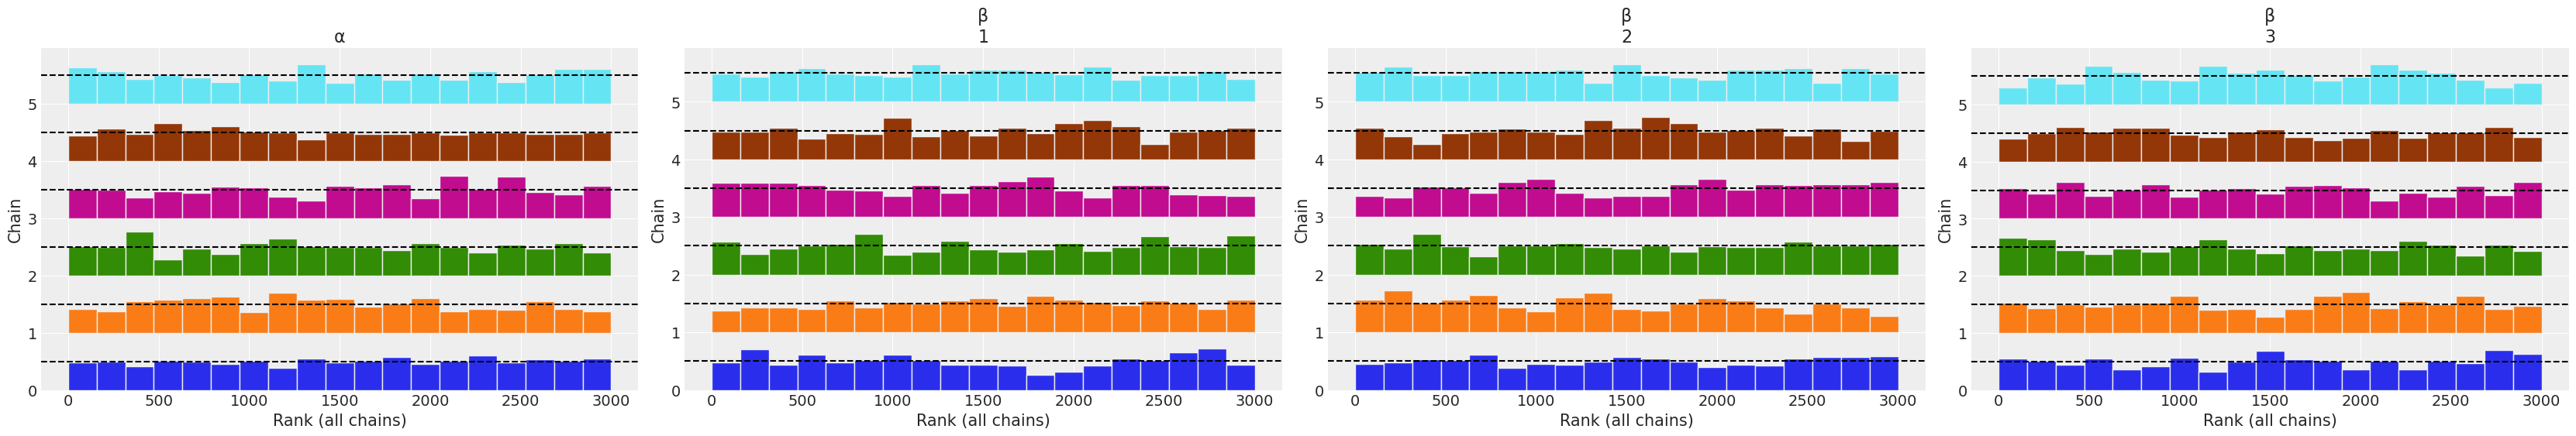

In [55]:
using StatsPlots, Plots

# MCMCChains integrates with StatsPlots
plot(posterior_chains)

using ArviZ, ArviZPythonPlots

use_style("arviz-darkgrid")

idata = ArviZ.from_mcmcchains(posterior_chains)
# plot_trace(idata)
plot_rank(idata)
gcf()

## fix operator

In [56]:
fixed_model = fix(model_adjusted, (; α = 0.5))

rand(fixed_model) # the difference is that the log density contributions from the fixed parameters are 0

(β = [6.182933344190579, -5.13014146084557, 0.5876514671492054], var"y[1]" = 0.028073632456385143, var"y[2]" = 12.255246877114978, var"y[3]" = 1010.0, var"y[4]" = 2803.6861316090967, var"y[5]" = 285.2297809218673, var"y[6]" = 1.9811852015193734, var"y[7]" = 21.94300367914334, var"y[8]" = 7.9301679273746135, var"y[9]" = 15718.38564604587, var"y[10]" = 3.190052865686439, var"y[11]" = 105843.90360148986, var"y[12]" = 1.5961904590848766, var"y[13]" = 7.790066131952092, var"y[14]" = 928.9555512777117, var"y[15]" = 32990.71998381533, var"y[16]" = 2.019863467437785, var"y[17]" = 0.03163231076633088, var"y[18]" = 363.7640861257433, var"y[19]" = 1516.2356974184456, var"y[20]" = 5816.634283834859, var"y[21]" = 5.729874486115783, var"y[22]" = 243428.553484945, var"y[23]" = 57433.06708091435, var"y[24]" = 931.7196158512297, var"y[25]" = 0.4028817855631081, var"y[26]" = 0.44757396551690437, var"y[27]" = 1626.6167788117311, var"y[28]" = 15.396199134263771, var"y[29]" = 2065.1348158816327, var"y[30]"

## Posterior predictive check

In [57]:
plot_posterior_pred_check(model_adjusted, posterior_chains, y, event)

UndefVarError: UndefVarError: `mm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Measures in the current active module Main

## LOO and LOO-PIT

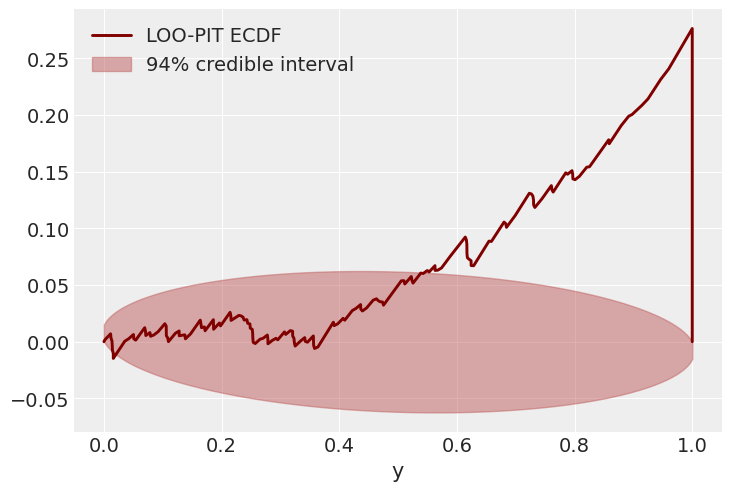

In [58]:
# Extract parameter samples from the chain
parameter_samples = MCMCChains.get_sections(posterior_chains, :parameters)

# Compute pointwise log likelihoods (returns an `OrderedDict`)
log_likelihood_dict = DynamicPPL.pointwise_loglikelihoods(
    conditioned_model, # used the conditioned model for pointwise log likelihoods
    parameter_samples,
)

# Compute posterior predictive samples
posterior_predictive_chain = DynamicPPL.predict(
    model_adjusted, # Use the unconditioned model for prediction
    parameter_samples,
)

# Reformat the log likelihoods into an array suitable for ArviZ
# Dimensions: (draws, chains, observations)
n_draws, n_params, n_chains = size(posterior_chains)
n_obs = length(y)
log_lik_values = Array{Float64}(undef, n_draws, n_chains, n_obs)
post_pred_values = Array{Float64}(undef, n_draws, n_chains, n_obs)

for i = 1:n_obs
    vn_str = "y[$i]"
    vn_sym = Symbol(vn_str)

    log_lik_values[:, :, i] .= log_likelihood_dict[vn_str]
    post_pred_values[:, :, i] .=
        dropdims(posterior_predictive_chain[[vn_sym],].value, dims = 2)
end

log_likelihood_data = (; y = log_lik_values)
posterior_predictive_data = (; y = post_pred_values)

idata_loo = ArviZ.from_mcmcchains(
    posterior_chains;
    log_likelihood = log_likelihood_data,
    posterior_predictive = posterior_predictive_data,
    observed_data = (; y = y),
    coords = (obs_id = 1:n_obs, coef_dim = 1:size(X, 2)),
    dims = (y = [:obs_id], β = [:coef_dim]),
)

loo_result = ArviZ.loo(idata_loo)

log_weights = loo_result.psis_result.log_weights
loo_pit_values = ArviZ.loo_pit(idata_loo, log_weights)

plot_loo_pit(idata_loo; y = "y", ecdf = true, color = "maroon")
gcf()

## Model with individual frailty (vectorized submodel approach)

In [59]:
@model function vectorized_gamma_frailties_submodel(n::Int, k::Real)
    frailties ~ Turing.arraydist([Gamma(k, k) for _ = 1:n])
end

@model function aft_weibull_frailty_age_sub(X, event, censoring_time)
    n, p = size(X)

    α ~ LogNormal(0, 1.5)
    β ~ MvNormal(zeros(p), 10I)
    k ~ Gamma(2, 2)

    v = Vector{Real}(undef, n)
    v ~ to_submodel(vectorized_gamma_frailties_submodel(n, k))

    θ_base = exp.(X * β)

    y = Vector{Real}(undef, n)
    for i = 1:n
        d = Weibull(α, θ_base[i] / (v[i]^(1 / α)))

        if event[i]
            y[i] ~ d
        else
            y[i] ~ censored(d; upper = censoring_time[i])
        end
    end

    return (; α, β, v, k, y)
end

model_frailty = aft_weibull_frailty_age_sub(X, event, censoring_time)
conditioned_model_frailty = model_frailty | (; y = y)

rand(conditioned_model_frailty)

posterior_chains_frailty = sample(
    conditioned_model_frailty,
    NUTS(; adtype = AutoReverseDiff(; compile = true)),
    MCMCThreads(),
    1000,
    6;
    n_adapt = 500,
)

plot_posterior_pred_check_frailty(
    model_frailty,
    posterior_chains_frailty,
    y,
    event,
)


Sampling (6 threads)   0%|                              |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 9.765625e-5
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 1.52587890625e-6
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
┌ Info: Found initial step size
│   ϵ = 1.3877787807814458e-18
└ @ Turing.Inference /Users/xiandasun/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
Sampling (6 threads)  17%|█████                         |  ETA: 0:02:16
Sampling (6 threads)  33%|█

UndefVarError: UndefVarError: `mm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Measures in the current active module Main